In [268]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances

# ======
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
from functions.rnn_cryptic_equals import convert_seq2inputs, calculate_output, onehot2seq 

# Functions

In [2]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.000001)


def train(sequence, label ,model ,optimizer ,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 



def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model


def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict))

    return inps

def predcorr(mods, tests, plot_corr = True):
    dfs1 = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
    all_dfs1 = pd.concat(dfs1) 
    preds, labs = all_dfs1['pred'], all_dfs1['label']
    xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)
    r2_val = r2_score(all_dfs1['pred'],all_dfs1['label'])
    df_fin = all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False)
    if plot_corr:
        for d in dfs1:
            plt.scatter(d['label'], d['pred'])
        plt.plot(xy,xy)
        plt.xlabel('Ground truth')
        plt.ylabel('Model prediction')
        plt.title('with primitive training, R^2 = ' + str(round(r2_val, 2)) )
             
    return r2_val, df_fin, all_dfs1  

# -----------------
# Generating trials
# -----------------

def generate_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [inp, '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_self(op, inputs):
    seq = []
    for inp in inputs:
        trial = generate_trials(op, inp, inp)
        seq += trial
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse_primitives(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    n = int(len(inputs1)/2)
    for i in range(n):
        trial = [inputs1[i], (op, inputs2[i+n]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)
    
def heatmap_acc(num_inputs, df, ax):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    map_syms = total_syms[:num_inputs]
    data_accs = np.empty((num_inputs, num_inputs))
    data_accs[:] = np.NaN
    for r, trial in enumerate(df.index):
        i = map_syms.index(eval(trial)[0])
        j = map_syms.index(eval(trial)[2])
        acc = round(df.iloc[r]['acc'], 2)
        data_accs[i,j] = acc
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(num_inputs), labels=map_syms)
    ax.set_yticks(np.arange(num_inputs), labels=map_syms)

    #cmap = mpl.colors.ListedColormap(['yellow', 'orange', 'darkorange','red'])
    from matplotlib import cm
    new_reds = cm.get_cmap('Reds', 10)
    cmap=new_reds
    bounds = list(np.arange(0,1.1,0.1))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(data_accs, cmap=cmap, norm=norm)

    # Loop over data dimensions and create text annotations.
    for i in range(num_inputs):
        for j in range(num_inputs):
            if np.isnan(data_accs[i, j]):
                pass
            else:
                text = ax.text(j,i, data_accs[i, j],
                              ha="center", va="center", color="black", fontsize=12)


In [938]:
df1 =pd.DataFrame( {'a': [1,2,3, 9, 9, 5]})
df2 =pd.DataFrame( {'a': [1,2,3, 4, 5, 7]})

In [942]:
list(df2.index.intersection(df1.index))

[0, 1, 2, 3, 4, 5]

# RNN setup

In [1225]:
## running function

def fully_trained_rnns(res):

    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
   
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:], 'test_acc': acc_test[-1,:]}) 
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    ft_test_acc = fully_trained.test_acc
    fully_trained_idx = fully_trained.index
    
    final_accs = pd.DataFrame({'train_acc': acc_train_p[-1,:], 'test_acc_p': acc_test_p[-1,:]}) 
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    ft_test_acc_p = fully_trained.test_acc_p
    fully_trained_idx_p = fully_trained.index
    
    ft_idx = list(fully_trained_idx_p.intersection(fully_trained_idx))
    
    ft_cue_dicts = [cue_dicts[i] for i in ft_idx]
    ft_tests = [tests[i] for i in ft_idx]
    ft_mods = [mods[i] for i in ft_idx]
    ft_mods_p = [mods_p[i] for i in ft_idx]
    
    return ft_mods, ft_mods_p, ft_tests, ft_cue_dicts, ft_test_acc, ft_test_acc_p 
    

def run_exp(trainseqs_old ,trainseqs_old_p, testseqs_old, cue_dict):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs = change_dict(trainseqs_old_p, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_p = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    model_p = copy.deepcopy(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)
    
    optimizer = torch.optim.Adam(model_p.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model_p,optimizer,criterion, trainset_p, [trainset_p, testset], epochs)
    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset,
           'loss_p':loss2, 'acc_p':acc2, 'mod_p': model_p}

def run_plot(trainseqs, trainseqs_p, testseqs, cue_dict):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, trainseqs_p, testseqs, cue_dict) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    losses_p = np.hstack([r['loss_p'] for r in res])
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
    
    plotNNs([losses], [acc_train, acc_test], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'no pretraining', shift = 0)
    plotNNs([losses_p], [acc_train_p, acc_test_p], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'with pretraining', shift = 0)
    
    return {'res':res, 'mods':mods, 'mods_p':mods_p, 'tests': tests, 'cue_dicts': cue_dicts,\
            'acc_train': acc_train, 'acc_train_p': acc_train_p,\
            'acc_test': acc_test, 'acc_test_p': acc_test_p}
            
#    ft_mod, ft_mod_p,  ft_test, ft_cue_dict, ft_test_acc, ft_test_acc_p  = fully_trained_rnns(res)

#     return {'res':res, 'ft_mods':ft_mod, 'ft_mods_p':ft_mod_p, 'ft_tests': ft_test, 'ft_cue_dicts': ft_cue_dict,\
#             'ft_test_acc': ft_test_acc, 'ft_test_acc_p': ft_test_acc_p}


In [1226]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1200
num_sims = 104

# Experiments

Final accuracy against ratio of other/self



In [1227]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
input_vals.sort()
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(all_syms)
rp = generate_other_reverse_primitives('+', all_syms)
print(p)
print(rp)

{'A': 7, 'B': 11, 'C': 12, 'D': 13}
[['A', '=', 7], ['B', '=', 11], ['C', '=', 12], ['D', '=', 13]]
[['A', ('+', 'C'), '=', 19], ['B', ('+', 'D'), '=', 24]]


In [ ]:
num_sims = 32
trainseqs = generate_other(ops, all_syms[:-1]) + rp
trainseqs_p = generate_other(ops, all_syms[:-1])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, trainseqs_p, testseqs, cue_dict)

trainseqs  [['A', ('+', 'B'), '=', 18], ['B', ('+', 'C'), '=', 23], ['C', ('+', 'A'), '=', 19], ['A', ('+', 'C'), '=', 19], ['B', ('+', 'D'), '=', 24]]
testseqs  [['A', ('+', 'A'), '=', 14], ['A', ('+', 'B'), '=', 18], ['A', ('+', 'C'), '=', 19], ['A', ('+', 'D'), '=', 20], ['B', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 22], ['B', ('+', 'C'), '=', 23], ['B', ('+', 'D'), '=', 24], ['C', ('+', 'A'), '=', 19], ['C', ('+', 'B'), '=', 23], ['C', ('+', 'C'), '=', 24], ['C', ('+', 'D'), '=', 25], ['D', ('+', 'A'), '=', 20], ['D', ('+', 'B'), '=', 24], ['D', ('+', 'C'), '=', 25], ['D', ('+', 'D'), '=', 26]]


In [1219]:
len(res1['ft_mods_p'])

5

In [1214]:

res1['ft_test_acc_p']

0     0.3750
1     0.3750
2     1.0000
3     0.3125
5     0.5625
6     0.4375
7     0.4375
8     1.0000
9     0.7500
10    0.4375
11    0.4375
13    0.4375
Name: test_acc_p, dtype: float64

In [1211]:
m = 8

print('no prim ', res1['ft_test_acc'][m])
print('with prim ', res1['ft_test_acc_p'][m])

KeyError: 8

In [1188]:
len(cue_dicts1)

12

In [1186]:
mods1 = res1['ft_mods']
cue_dicts1 = res1['ft_cue_dicts']
testseq = generate_trials(ops, all_syms, all_syms)
testseq = change_dict(testseq, cue_dicts1[m])
train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
hiddens1, trials1 = get_reps(mods1[m], [testset], hidden_size)
distmats = []
for h in range(4):
    first_hid = np.array([hid[h,:] for hid in hiddens1])
    dm = np.array(first_hid)
    distmats.append(euclidean_distances(dm))

mods2 = res1['ft_mods_p']
cue_dicts2 = res1['ft_cue_dicts']
testseq = generate_trials(ops, all_syms, all_syms)
testseq = change_dict(testseq, cue_dicts2[m])
train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
hiddens2, trials2 = get_reps(mods2[m], [testset], hidden_size)
distmats_p = []
for h in range(4):
    first_hid = np.array([hid[h,:] for hid in hiddens2])
    dm = np.array(first_hid)
    distmats_p.append(euclidean_distances(dm))

print(cue_dicts1[m])

IndexError: list index out of range

In [1176]:
testseq

[['A', ('+', 'A'), '=', 4],
 ['A', ('+', 'B'), '=', 7],
 ['A', ('+', 'C'), '=', 9],
 ['A', ('+', 'D'), '=', 14],
 ['B', ('+', 'A'), '=', 7],
 ['B', ('+', 'B'), '=', 10],
 ['B', ('+', 'C'), '=', 12],
 ['B', ('+', 'D'), '=', 17],
 ['C', ('+', 'A'), '=', 9],
 ['C', ('+', 'B'), '=', 12],
 ['C', ('+', 'C'), '=', 14],
 ['C', ('+', 'D'), '=', 19],
 ['D', ('+', 'A'), '=', 14],
 ['D', ('+', 'B'), '=', 17],
 ['D', ('+', 'C'), '=', 19],
 ['D', ('+', 'D'), '=', 24]]

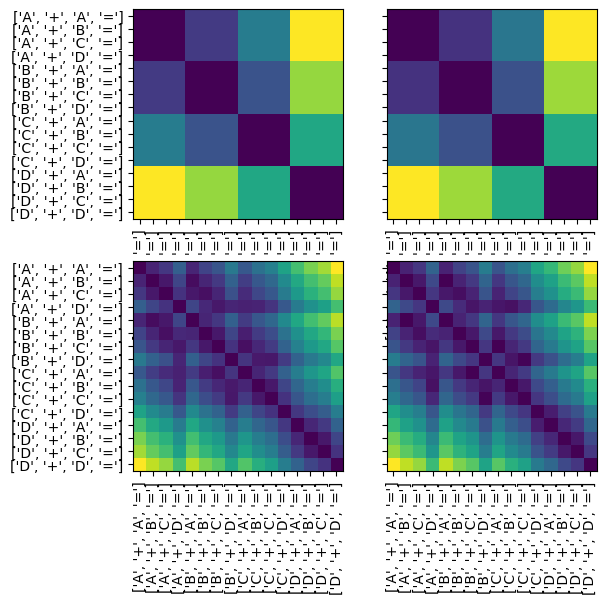

In [1177]:
fig, axs = plt.subplots(2,2, sharey=True)
for i in range(4):
    ax = axs[math.floor(i/2), i%2]
    ax.imshow(distmats[i])
    g1 = ax.set_yticks(np.arange(len(trials)), labels=trials, rotation=0)
    g1 = ax.set_xticks(np.arange(len(trials)), labels=trials, rotation=90)


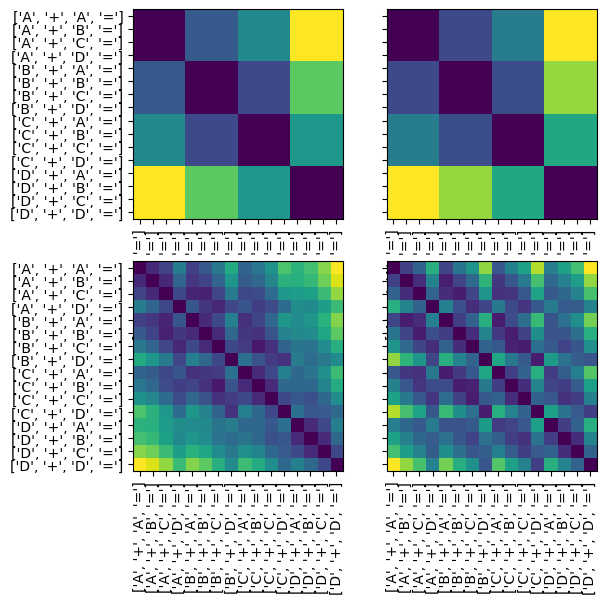

In [1178]:
fig, axs = plt.subplots(2,2, sharey=True)
for i in range(4):
    ax = axs[math.floor(i/2), i%2]
    ax.imshow(distmats_p[i])
    g1 = ax.set_yticks(np.arange(len(trials)), labels=trials, rotation=0)
    g1 = ax.set_xticks(np.arange(len(trials)), labels=trials, rotation=90)


In [1179]:
colors2 = ['green', 'blue', 'orange', 'red']*4
colors1 = ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4

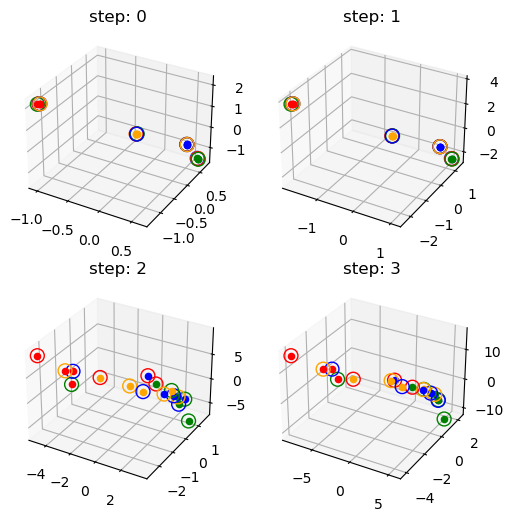

In [1180]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2, subplot_kw=dict(projection='3d'))

for j, dist in enumerate(distmats):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=3)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(trials)):
        ax.scatter(X_transform[i,0], X_transform[i,1],X_transform[i,2], color = colors1[i])
        ax.scatter(X_transform[i,0], X_transform[i,1],X_transform[i,2], s=100, facecolors='none', edgecolors=colors2[i])

    
    

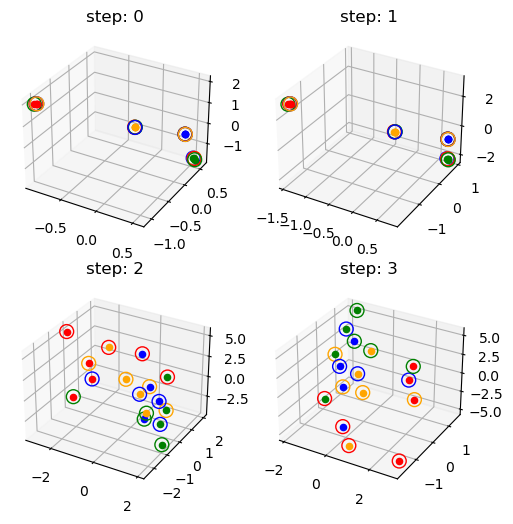

In [1181]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2, subplot_kw=dict(projection='3d'))

for j, dist in enumerate(distmats_p):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=3)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(trials)):
        ax.scatter(X_transform[i,0], X_transform[i,1],X_transform[i,2], color = colors1[i])
        ax.scatter(X_transform[i,0], X_transform[i,1],X_transform[i,2], s=100, facecolors='none', edgecolors=colors2[i])

    
    

In [ ]:
## red is far away - more orthogonal? parrallelism score between reps?

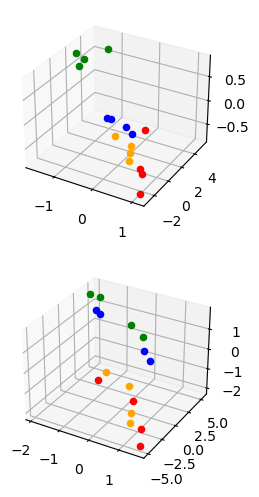

In [858]:
mds = MDS(dissimilarity='precomputed',random_state=0, n_components=3)
X_transform1 = mds.fit_transform(distmat1)

mds = MDS(dissimilarity='precomputed',random_state=0, n_components=3)
X_transform2 = mds.fit_transform(distmat2)

plt.rcParams['figure.figsize'] = 6, 6
fig, [ax1, ax2] = plt.subplots(2,1, subplot_kw=dict(projection='3d'))

for i in range(len(trials)):
    ax1.scatter(X_transform1[i,0], X_transform1[i,1],X_transform1[i,2], color = colors1[i])
    #ax1.annotate(trials1[i], (X_transform1[i,0], X_transform1[i,1], X_transform1[i,2]))
    
for i in range(len(trials)):
    ax2.scatter(X_transform2[i,0], X_transform2[i,1],X_transform2[i,2], color = colors1[i])
    #ax2.annotate(trials2[i], (X_transform2[i,0], X_transform2[i,1], X_transform2[i,2]))

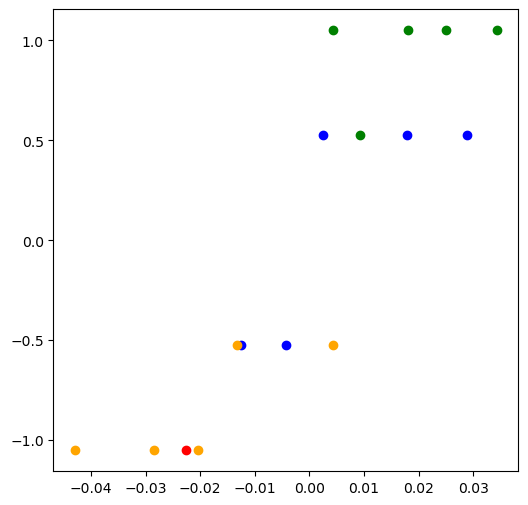

In [547]:
mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
X_transform = mds.fit_transform(distmat)

for i in range(len(trials)):
    plt.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i])
   # plt.annotate(trials[i], (X_transform[i,0], X_transform[i,1]))

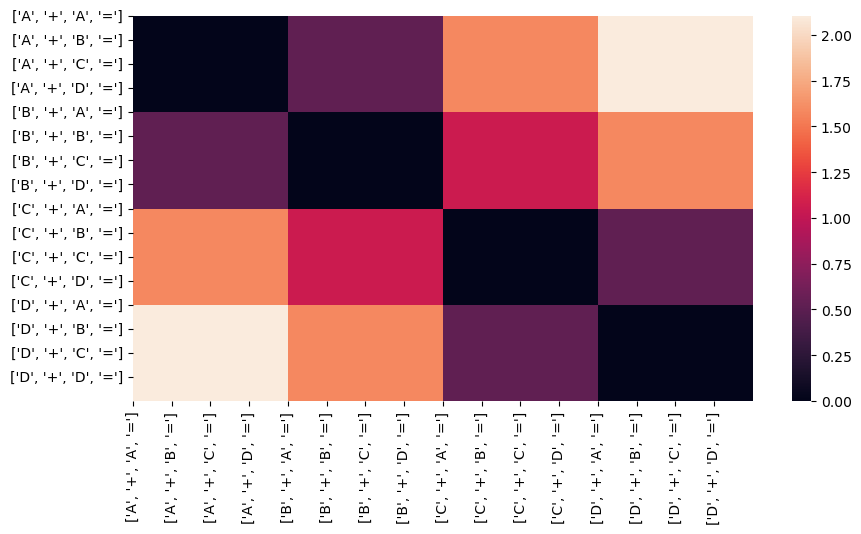

In [540]:
mods = res2['ft_mods']
cue_dicts = res2['ft_cue_dicts']

testseq = generate_trials(ops, all_syms, all_syms)
testseq = change_dict(testseq, cue_dicts[m])
train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)

hiddens, trials = get_reps(mods[m], [testset], hidden_size)

first_hid = np.array([hid[h,:] for hid in hiddens])
dm = np.array(first_hid)
distmat = euclidean_distances(dm)

sns.heatmap(distmat)
g = plt.yticks(np.arange(len(trials)), labels=trials, rotation=0)
g = plt.xticks(np.arange(len(trials)), labels=trials, rotation=90)


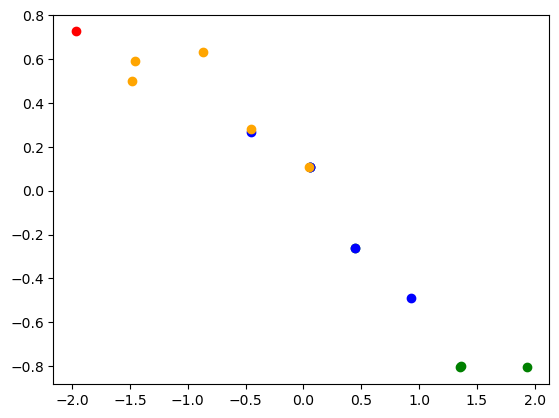

In [504]:
mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
X_transform = mds.fit_transform(distmat)

for i in range(len(trials)):
    plt.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i])
   # plt.annotate(trials[i], (X_transform[i,0], X_transform[i,1]))

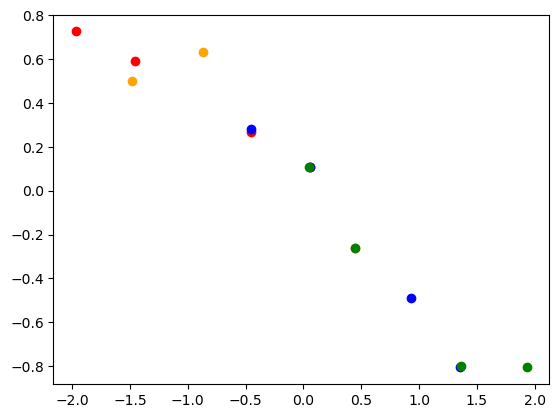

In [505]:
mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
X_transform = mds.fit_transform(distmat)

for i in range(len(trials)):
    plt.scatter(X_transform[i,0], X_transform[i,1], color = colors2[i])
   # plt.annotate(trials[i], (X_transform[i,0], X_transform[i,1]))

In [336]:
def get_reps(model, testdata, hidden_size):
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 


In [163]:
X_transform

array([[ 1.66105421, -1.99194208],
       [ 1.70086176, -1.95725852],
       [ 1.70095548, -1.95717504],
       [ 1.70770431, -1.95114006],
       [ 0.09224353, -0.36963429],
       [ 0.08834215, -0.3725523 ],
       [ 0.08744692, -0.37322057],
       [ 0.08749248, -0.37318657],
       [-0.81799046,  0.98448949],
       [-0.81846097,  0.98419695],
       [-0.81801967,  0.98447132],
       [-0.81882116,  0.98397317],
       [-0.96177784,  1.35308328],
       [-0.96258141,  1.35261174],
       [-0.96317366,  1.35226328],
       [-0.96527566,  1.35102021]])

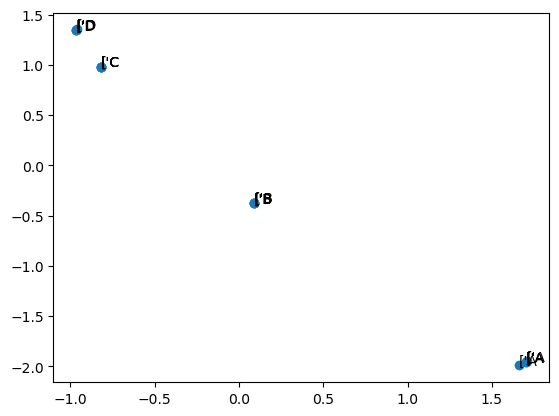